In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import timeit
import math
from mpmath import *
from datetime import datetime, timedelta
#import xarray

In [2]:
#wf = pd.read_csv("../Data_Sets/weeplaces/weeplaces/weeplace_checkins_scrubbed_Reordered_DistinctLocs.csv")
wf = pd.read_csv("../Data_Sets/weeplaces/weeplaces/weeplace_checkins_scrubbed_Reordered_DistinctLocs_QPiRog2.csv")

In [3]:
wf = wf.drop(columns = ['Unnamed: 0','Year','Week','Delta_t','Delta_r','Counts'])
wf['datetime'] = pd.to_datetime(wf['datetime'])

In [4]:
usrs = [wf.groupby('userid').count().index.to_list()]

In [141]:
'''Simulates Lempel Ziv algorithm to find an estimate for the true entropy of 
a time-ordered user's trajectory

Lamba_i : The length of the shortest substring starting at position i which doesn’t previously
appear from position 1 to i−1. 
uniquelocs: The id of each unique location.
locdict: The substrings of visitation patterns that haven't been seen. 
Each index in locdict represents the beginning of a trajectory starting at 
a unique location. The order of the index is the order in which new starting locations are found
lendict: An array of lengths of substrings in locdict
visited: The continuous string of visited locations'''


''' Function takes two users, finds their dictionaries of subtrajectories
Returns the proportion of subtrajectories of the ego that are also contained in the dictionary of the alter'''
def LZ_compare(egoID,alterID):
    dictego = Lempel_Ziv_dict(egoID)
    dictalter = Lempel_Ziv_dict(alterID)
    return len([w for w in dictalter if w in dictego])/len(dictego)


'''Returns the dictionary of subtrajectories of a user'''
def Lempel_Ziv_dict(egoID):
    locs = wf[(wf['userid']==usrs[0][egoID]) & wf['placeid'].notna()]['placeid'].to_list()
    Lambda_i = 0
    visited = ''
    dictLZ = []
    i = 0
    while i < len(locs):
        j = 0
        if visited == '':
            Lambda_i += 1
            visited = visited + locs[i]
            dictLZ.append(locs[i])
            substr = locs[1]
            i+=1
        else:
            while i < len(locs):
                if (i+j) == (len(locs) - 1):
                    substr = substr + locs[i+j]
                    dictLZ.append(substr)
                    #visited = visited + locs[i]
                    Lambda_i += j+1
                    i += 1
                    break
                if (substr in dictLZ):
                    j += 1
                    substr = substr + locs[i+j]
                else:
                    Lambda_i += j+1
                    #visited = visited + substr
                    dictLZ.append(substr)
                    i += 1
                    substr = locs[i]
                    j = 0
                    break
#    print(visited)
    return dictLZ
'''
def Lempel_Ziv(locs):
    Lambda_i = 0
    visited = ''
    i = 0
    while i < len(locs):
        substr = ''
        j = 0
        if visited == '':
            Lambda_i += 1
            visited = visited + locs[i]
            i+=1
        else:
            while i < len(locs):
                substr = substr + locs[i+j]
                if (i+j) == (len(locs) - 1):
                    visited = visited + locs[i]
                    Lambda_i += j+1
                    i += 1
                    break
                if (substr in visited):
                    j += 1
                else:
                    Lambda_i += j+1
                    visited = visited + locs[i]
                    i += 1
                    break
    return len(locs)*np.log2(len(locs))/Lambda_i
'''

'''Uncorrelated (Shannon) entropy'''
def UncEntropy(LocCounts):
    LocCounts = np.array(LocCounts/np.sum(LocCounts))
    terms = LocCounts*np.log2(LocCounts)
    return -1*np.sum(terms)
       
'''Entropy of a completely random process'''
def RandEntropy(numlocs):
    return np.log2(numlocs)

'''Fano Inequality'''
def Fano(Pi_max, N, S):
    return np.log2(N-1)-S+Pi_max*np.log2((1/Pi_max - 1)*(1/(N-1))) - np.log2(1-Pi_max)
            

In [309]:
''' Finds the top alters of a given ego
Top alters are decided by the proportion of number of locations shared between the ego and alter to 
the number of total locations the ego has visited. This is used as a proxy for friendship'''
def TopAlters(egoID):
    #Yields top alters of a given ego based on the number of mutual locations the two have visited.
    ego = wf[(wf['userid']==usrs[0][egoID]) & wf['placeid'].notna()].groupby('placeid').count().index.to_list()
    lenego = len(ego)
    indices = np.arange(0,len(usrs[0]),1)
    alters = []
    for usr in usrs[0]:
        if usr == usrs[0][egoID]:
            alters.append(0)
        else:
            locs = wf[(wf['userid']==usr) & wf['placeid'].notna()].groupby('placeid').count().index.to_list()
            alters.append(len([w for w in locs if w in ego])/lenego)
    return [x for _,x in sorted(zip(alters,indices),reverse=True)][:15]

''' Function to get the proportion of number of locations shared between the ego and alter to 
the number of total locations the ego has visited.'''
def mutualLocs(egoID,alterid):
    ego = wf[(wf['userid']==usrs[0][egoID]) & wf['placeid'].notna()].groupby('placeid').count().index.to_list()
    locs = wf[(wf['userid']==usrs[0][alterid]) & wf['placeid'].notna()].groupby('placeid').count().index.to_list()
    return (len([w for w in locs if w in ego])/lenego)

'''Probability of a user visiting a location based on the frequency of visitation over the course of their trajectory'''
def Px(egoID):
    lst = wf[(wf['userid']==usrs[0][egoID]) & wf['placeid'].notna()].groupby('placeid')['userid'].count().to_list()
    return np.array(lst)/sum(lst)

'''Rounds a datetime to the nearest hour'''
def hr_rnd(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)+timedelta(hours=t.minute//30))

'''Rounds an array of datetimes to the nearest hour'''
def hour_rounder(times):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    i = 0
    for t in times:
        times[i] = hr_rnd(t)
        i+=1
    return times

'''Probability of alter y interacting with the ego at arbitray locations'''
def Py(alters,egoID):
    t_x = hour_rounder(wf[(wf['userid']==usrs[0][egoID]) & wf['placeid'].notna()]['datetime'].to_list())
    loc_x = wf[(wf['userid']==usrs[0][egoID]) & wf['placeid'].notna()]['placeid'].to_list()
#    uniquelocs = wf[(wf['userid']==usrs[0][egoID]) & wf['placeid'].notna()].groupby('placeid').count().index.to_list()
    totcounts = 0
    locprobs = [0]
    for j in range(len(alters)):
        loc_y = wf[(wf['userid']==usrs[0][alters[j]]) & wf['placeid'].notna()]['placeid'].to_list()
        t_y = hour_rounder(wf[(wf['userid']==usrs[0][alters[j]]) & wf['placeid'].notna()]['datetime'].to_list())
        prev = 0
        for i in range(len(t_x)):
            if t_x[i] in t_y[prev:]:
                prev = t_y.index(t_x[i])
                if (loc_x[i] == loc_y[prev]): # or (t_x[i] + timedelta(hours=1) == t_y[prev]) or (t_x[i] - timedelta(hours=1) == t_y[prev]):
                    locprobs[j]+=1
                    totcounts+=1
        locprobs.append(0)
    del locprobs[-1]
    return np.array(locprobs)/totcounts

'''Probability of alter y interacting with the ego at location x'''          
def Pxy(alters,egoID):
    t_x = hour_rounder(wf[(wf['userid']==usrs[0][egoID]) & wf['placeid'].notna()]['datetime'].to_list())
    loc_x = wf[(wf['userid']==usrs[0][egoID]) & wf['placeid'].notna()]['placeid'].to_list()
    uniquelocs = wf[(wf['userid']==usrs[0][0]) & wf['placeid'].notna()].groupby('placeid').count().index.to_list()
    totcounts = 0
    locprobs = [[0]*len(uniquelocs)]
    for j in range(len(alters)):
        loc_y = wf[(wf['userid']==usrs[0][alters[j]]) & wf['placeid'].notna()]['placeid'].to_list()
        t_y = hour_rounder(wf[(wf['userid']==usrs[0][alters[j]]) & wf['placeid'].notna()]['datetime'].to_list())
        prev = 0
        for i in range(len(t_x)):
            if t_x[i] in t_y[prev:]:
                prev = t_y.index(t_x[i])
                if loc_x[i] == loc_y[prev]:
                    locprobs[j][uniquelocs.index(loc_x[i])]+=1
                    totcounts+=1
        locprobs.append([0]*len(uniquelocs))
    del locprobs[-1]
    print(totcounts)
    return np.array(locprobs)/totcounts

'''Gets Marginal Probability of location probabilities for the ego'''
def PxMarg(probxy):
    return np.nansum(probxy, axis = 0)

'''Gets Marginal Probability of interactions with alter y'''
def PyMarg(probxy):
    return np.nansum(probxy, axis = 1)

'''Gets Mutual Information based on Marginal Probabilities of P(x,y)'''
def MutualInfMarg(alters,egoID):
    probxy = Pxy(alters,egoID)
    probx = PxMarg(probxy)
    proby = PyMarg(probxy)
    IXY = np.multiply(probxy,np.log2(probxy/np.outer(proby,probx)))
    #return IXY
    return np.nansum(IXY)

'''Norm of Mutual Information based on Marginalization'''
def normMutInfMarg(alters,egoID):
    probxy = Pxy(alters,ego)
    return MutualInf(alters,egoID)/np.sqrt(Shannon(PxMarg(probxy))*Shannon(PyMarg(probxy)))

'''Shannon Entropy'''
def Shannon(probs):
    #return np.multiply(probs,np.log2(probs))
    return (-1)*np.nansum(np.multiply(probs,np.log2(probs)))

    
def MutualInf(alters,egoID):
    probxy = Pxy(alters,egoID)
    probx = Px(egoID)
    proby = Py(alters,egoID)
    IXY = np.multiply(probxy,np.log2(probxy/np.outer(proby,probx)))
    #return IXY
    return np.nansum(IXY)

def normMutInf(alters,egoID):
    return MutualInfMarg(alters,egoID)/np.sqrt(Shannon(Px(egoID))*Shannon(Py(alters,egoID)))

In [158]:
start = timeit.default_timer()

TopAltersUsr0 = TopAlters(0)

stop = timeit.default_timer()
print("Time: ", stop-start)

Time:  49738.3883777


In [314]:
TopAltersUsr0 = [3608, 5407,
 1524,
 956,
 9593,
 8,
 10419,
 9252,
 9578,
 9168,
 7448,
 8147,
 5399,
 9594,
 3865]

[3608,
 5407,
 1524,
 956,
 9593,
 8,
 10419,
 9252,
 9578,
 9168,
 7448,
 8147,
 5399,
 9594,
 3865]

In [307]:
MutInf = []
for i in range(len(TopAltersUsr0))[1:]:
    MutInf.append(normMutInf(TopAltersUsr0[:i],0))

C:\Users\Sean\Anaconda3\lib\site-packages\ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Sean\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Sean\Anaconda3\lib\site-packages\ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in log2
C:\Users\Sean\Anaconda3\lib\site-packages\ipykernel_launcher.py:114: RuntimeWarning: invalid value encountered in multiply
C:\Users\Sean\Anaconda3\lib\site-packages\ipykernel_launcher.py:96: RuntimeWarning: divide by zero encountered in log2
C:\Users\Sean\Anaconda3\lib\site-packages\ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in multiply


In [308]:
MutInf

[nan,
 nan,
 0.4169456254927237,
 0.4169456254927237,
 0.4169456254927237,
 0.34244291043430497,
 0.45838420289661996,
 0.4583842028966199,
 0.4528737311867059,
 0.4528737311867059,
 0.4528737311867059,
 0.39629810099822477,
 0.35923100856238366,
 0.35923100856238366]

In [175]:
LZ = []
for usr in TopAltersUsr0:
    LZ.append(LZ_compare(0,usr))
LZ

[0.15921787709497207,
 0.17039106145251395,
 0.14804469273743018,
 0.14804469273743018,
 0.09776536312849161,
 0.13966480446927373,
 0.2011173184357542,
 0.09217877094972067,
 0.08659217877094973,
 0.09217877094972067,
 0.09497206703910614,
 0.15921787709497207,
 0.10614525139664804,
 0.0670391061452514,
 0.08659217877094973]

In [302]:
LZfriend = []
mutlocs = []
lenegoo = len(wf[(wf['userid']==usrs[0][0]) & wf['placeid'].notna()].groupby('placeid').count().index.to_list())
for usr in Usr0Friends:
    if usr in usrs[0]:
        LZfriend.append(LZ_compare(0,usrs[0].index(usr)))
        mutlocs.append(len([w for w in wf[(wf['userid']==usr) & wf['placeid'].notna()].groupby('placeid').count().index.to_list() if w in ego])/lenegoo)
    else:
        LZfriend.append('nan')
        mutlocs.append('nan')
print(LZfriend)
print(mutlocs)

['nan', 0.036312849162011177, 0.09497206703910614, 0.07262569832402235, 0.0446927374301676, 0.05307262569832402]
['nan', 0.12195121951219512, 0.21951219512195122, 0.17073170731707318, 0.13414634146341464, 0.12195121951219512]


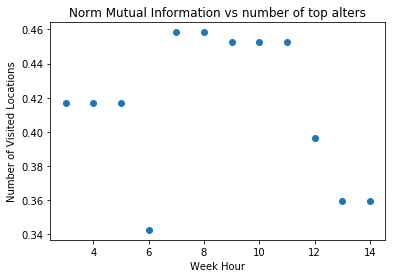

In [313]:
plt.title('Norm Mutual Information vs number of top alters')
plt.xlabel('Alter Number')
plt.ylabel('Norm Mutual Information')
plt.plot(np.arange(1,len(MutInf)+1,1), MutInf, 'o')

#plt.plot(xtest,ytest,'.')
#,label = 'data of jump lengths')
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()
#plt.xlim(-50,50)
#plt.ylim(-50,50)
plt.show()

In [232]:
wfriend = pd.read_csv("../Data_Sets/weeplaces/weeplaces/weeplace_friends.csv")

In [289]:
wfriend = wfriend.sort_values(by = ['userid1'])

In [291]:
for usr in TopAltersUsr0:
    print(usrs[0][usr])

gotetsu
kaichi-kuroda
butakao
atknktn
takechiyo-yamanaka
26
yoshihiro
smokeymonkey-highness
syochin
shinya-sakemoto
naoishix-paparabi
pinkpeco
kaerugeko
takehiko-kamijo
hiderows
